# Load Modules

In [160]:
import os, sys
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import xarray as xr
from scipy import interpolate
import time
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.patches as patches
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap


import matplotlib
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import numpy as np
import time
from datetime import date, timedelta
from matplotlib import animation
import matplotlib.animation as animation
import types
import matplotlib.lines as mlines
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
import nclcmaps
import pandas as pd
import xarray as xr
from scipy import interpolate
import operator
import multiprocessing
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.patches as patches

# Read in CM1 Output

In [161]:
ds = xr.open_dataset('/uufs/chpc.utah.edu/common/home/u1013082/cm1_parcels/high_freq_out/cm1_parcels_2s/cm1out.nc')
dsp = xr.open_dataset('/uufs/chpc.utah.edu/common/home/u1013082/cm1_parcels/high_freq_out/cm1_parcels_2s/cm1out_pdata.nc')

xposp = (dsp.x.values/100)+450
zposp = dsp.z.values
thp = dsp.th.values

#Get model output demensions
num_x = ds.nx
num_z = ds.nz

x = np.arange(0,num_x,1)
x_stag = np.arange(0,num_x+1,1) #staggered x-grid points
z = np.arange(0,num_z,1)
z_stag = np.arange(0,num_z+1,1) #staggered z-grid points

# Info to Initialize and Calculate Parcels

Variables based on their model output and desired parcels (set by user). The code initializes an array of parcels in the the y,z domain. It can be easily modified to also initialize in the x-domain.

In [162]:
num_seeds_z = 10 #Number of parcels in vertical (can be more than number of vertical levels) 
num_seeds_x = 1 #Number of parcels in y
time_steps = 3600 #Number of time steps to run trajectories back
start_time_step = 0 #Time step to start backwards trajectories at
hor_resolution = 100.0 #Horizontal resolution of model output (meters)
vert_resolution = 100.0 #Vertical resolution of model output. Only used in no-terrain runs. Calculated below for runs with terrain (meters)
time_step_length = 2.0 #Model output time step length (seconds)
desired_time_step_length = 2.0 #Time step length for calculations(seconds)
var_name1 = 'th' #Variable to record at each parcel's location throughout trajectory (code can be easily modified to add more)

Create empty arrays to x, y, and z positions of parcels and variable to track

In [163]:
xpos = np.zeros((time_steps, num_seeds_z, num_seeds_x))
ypos = np.zeros((time_steps, num_seeds_z, num_seeds_x))
zpos = np.zeros((time_steps, num_seeds_z, num_seeds_x))
zpos_grid = np.zeros((time_steps, num_seeds_z, num_seeds_x))
change_zs = np.zeros((time_steps, num_seeds_z, num_seeds_x))
variable1 = np.zeros((time_steps, num_seeds_z, num_seeds_x))

Initial location of seeds (set by user)

In [164]:
#x-position
xpos[0,:,:] = 400 #This example initializes all seeds at same x-position


#z-position
for i in range(num_seeds_z):
    zpos[0,i,:] = i #This example initializes seeds evenly starting at zero in z-deimension

#z-position for parcel validation with 'cm1out_pdata.nc''
zs = np.array(ds.zs[0,0,:]) #terrain height (m)
zh = np.array(ds.zh[0,:,0,:]) #height on model levels (m)
x_s = np.int(xpos[0,0,0])
zpos[0,:,0] = (zposp[0,:]-zs[x_s])/(zh[2,x_s]-zh[1,x_s])

## Initialize Surface Terrain Height and Calculate Vertical Grid-Spacing
CM1 output in terrain following so we must add the surface terrain height to the initial height of the parcels above the surface. Also, the vertical grid spacing changes above areas of terrain in CM1. We must read in the the vertical heights and calculate the the vertical grid spacing for each x,y grid point. This will be ignored if you are not using terrain.

In [165]:
#Check if run has terrain. If so, add  (if not, zs is zero and z-position should not be affected)
try:
    #Get vertical coordinates
    zh = np.array(ds.zh[0,:,0,:])
    #Create list of current coordinates for terrain addition
    xloc = np.array(xpos[0,:,:]-0.5).flatten()
    zloc = np.array(zpos[0,:,:]-0.5).flatten()
    coor_terrain = []
    for i in range(len(xloc)):
        coor_terrain.append((zloc[i], xloc[i]))
    #Get the actual inital height of the parcels. Not their height above the surface.
    zpos_terrain = np.array(zpos)
    
    #Substract zh[0,0] because we are dealing with staggered gridpoints (nkp1). Don't need to do if using u-interp
    #zpos_terrain[0,:,:] = np.reshape(interpolate.interpn((z,x), zh-zh[0,x_s]+zs[x_s], coor_terrain, method='linear', bounds_error=False, fill_value= 0), (num_seeds_z, num_seeds_x))
    zpos_terrain[0,:,:] = np.reshape(np.array(zposp[0,:]).flatten(),(num_seeds_z, num_seeds_x))
    
    #This gets us the grid spacing for the vertical grid
    z_grid = (zh[1:,:]-zh[:-1,:])


except:
    #No terrain runs
    zh = np.zeros((ds.nz, ds.nx))
    zpos_terrain = np.copy(zpos)*vert_resolution
    z_grid = np.ones((ds.nz-1, ds.nx))*vert_resolution

# Calculate Trajectories

In [166]:
#Loop over all time steps and compute trajectory
for t in range(0,time_steps-1):
    
    start = time.time() #Timer
    
    #Get model data ("start_time_step+t" for forward trajectories)
    t_out = np.int(t*np.int(desired_time_step_length/time_step_length))
    u = ds.u[start_time_step+t_out,:,0,:].values
    w = ds.w[start_time_step+t_out,:,0,:].values
    var1 = getattr(ds,var_name1)[start_time_step+t_out,:,0,:].values

                                
    #####################   Get x,y,z for variables ###########################
    ##  If the model output is terrain following, the change in surface      ##
    ##  height at each timestep must be added to the height (zpos) of the    ##
    ##  parcels.                                                             ##
    ###########################################################################
        
    #Get surface height grid
    try:
        zs = np.array(ds.zs[0,0,:])
    except:
        zs = np.zeros((ds.nx))  


    #Get previous and current x and y positions to calc change in surface height
    if t > 0:
        
        #x and y for one time step back
        xloc = np.copy(xpos[t-1,:,:]).flatten()
        coor_xminus1 = []
        for i in range(len(xloc)):
            coor_xminus1.append((xloc[i]))
            
            
        #xand y for current time step
        xloc = np.copy(xpos[t,:,:]).flatten()
        coor_x = []
        for i in range(len(xloc)):
            coor_x.append((xloc[i]))
            
        #Calc surface height at each time
        xminus1_h = np.interp(coor_xminus1, x, zs)
        x_h = np.interp(coor_x, x, zs)
        
        #Calc change in surface height during last timestep, which will be added to zpos
        change_zs[t,:,:] =  np.reshape(x_h - xminus1_h, (num_seeds_z, num_seeds_x))
    
    
    #Get get x, y, and z positions to calc parcel movement
    xloc = np.copy(xpos[t,:,:]).flatten()
    zloc = np.copy(zpos[t,:,:]-0.5).flatten()
    coor_var_xstag = []
    for i in range(len(xloc)):
        coor_var_xstag.append((zloc[i], xloc[i])) 
        
    xloc = np.copy(xpos[t,:,:]-0.5).flatten()
    zloc = np.copy(zpos[t,:,:]).flatten()
    coor_var_zstag = []
    for i in range(len(xloc)):
        coor_var_zstag.append((zloc[i], xloc[i])) 
        
        
    xloc = np.copy(xpos[t,:,:]-0.5).flatten()
    zloc = np.copy(zpos[t,:,:]-0.5).flatten()
    coor_var = []
    for i in range(len(xloc)):
        coor_var.append((zloc[i], xloc[i])) 
    #print(coor_var)
    
    #####################   Calc new xpos #####################################
    xpos[t+1,:,:] = xpos[t,:,:] + np.reshape(interpolate.interpn((z,x_stag), u, coor_var_xstag, method='linear', bounds_error=False, fill_value=np.nan)*desired_time_step_length/hor_resolution, (num_seeds_z, num_seeds_x))

    #####################   Calc new zpos #####################################
    #zpos grid spacing
    zpos_grid[t,:,:] = np.reshape(interpolate.interpn((z[:-1],x), z_grid, coor_var, method='linear', bounds_error=False, fill_value= 0), (num_seeds_z, num_seeds_x))
    #terrain-following (includes change in surface height). Effect of terrain decreases with height within doamin.
    #zpos[t+1,:,:]  = zpos[t,:,:] - change_zs[t,:,:]/zpos_grid[t,:,:]*(abs(zpos[t,:,:]-z_stag[-2])/z_stag[-2]) + np.reshape(interpolate.interpn((z_stag,x), w, coor_var_zstag, method='linear', bounds_error=False, fill_value= 0), (num_seeds_z, num_seeds_x))*desired_time_step_length/(zpos_grid[t,:,:])

    #terrain-height coordinates
    zpos_terrain[t+1,:,:]  = zpos_terrain[t,:,:] + np.reshape(interpolate.interpn((z_stag,x), w, coor_var_zstag, method='linear', bounds_error=False, fill_value= 0)*desired_time_step_length, (num_seeds_z, num_seeds_x))
    
    #xand y for current time step
    xloc = np.copy(xpos[t+1,:,:]).flatten()
    coor_x = []
    for i in range(len(xloc)):
        coor_x.append((xloc[i]-0.5))
    zs2 = np.interp(coor_x, x, zs)
    
    zpos[t+1,:,:] = np.reshape((zpos_terrain[t+1,:,:].flatten()-zs2.flatten())/zpos_grid[t,:,:].flatten(), (num_seeds_z, num_seeds_x))
        
    #Prevents parcel from going into ground
    xloc = np.copy(xpos[t,:,:]).flatten()
    coor_terrain = []
    for i in range(len(xloc)):
        coor_terrain.append((xloc[i]-0.5)) 
    surface_height = np.reshape(np.interp(coor_terrain, x, zs), (num_seeds_z, num_seeds_x))
    zpos_terrain[t,:,:] = zpos_terrain[t,:,:].clip(min=surface_height) 
    
    zpos = zpos.clip(min=0.5) #Prevents parcel from going into the ground
    
    
    #Variables
    variable1[t,:,:] = np.reshape(interpolate.interpn((z,x), var1, coor_var, method = 'linear', bounds_error=False, fill_value= np.nan), (num_seeds_z, num_seeds_x))  
    
    #Timer
    stop = time.time()
    #print("Integration {:01d} took {:.2f} seconds".format(t, stop-start))
    
    
    
    
##############  Get variable data for final time step #########################
t = time_steps-1

#Get get x, y, and z positions to calc parcel movement
xloc = np.copy(xpos[t,:,:]).flatten()
zloc = np.copy(zpos[t,:,:]).flatten()
coor_var = []
for i in range(len(xloc)):
    coor_var.append((zloc[i], xloc[i])) 


#Variables
variable1[t,:,:] = np.reshape(interpolate.interpn((z,x), var1, coor_var_zstag, method = 'linear', bounds_error=False, fill_value= np.nan), (num_seeds_z, num_seeds_x))

# Save Trajectory Data
The x, y, and z position and user-specified variable values are saved in 3D numpy arrays. The first dimension is time and the other two are the positions and values of variables of all the parcels at that specifc time.

In [167]:
np.save('xpos', xpos)
np.save('ypos', ypos)
np.save('zpos', zpos_terrain)
np.save('%s' %var_name1, variable1)

# Plot

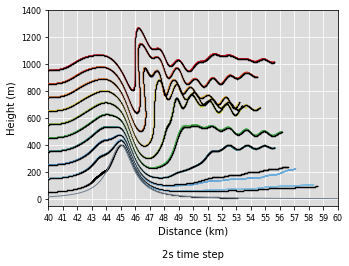

In [172]:
###############################################################################
###################  Backward Trajectory Plot  ################################
###############################################################################

fig = plt.figure(num=None, figsize=(24,16), facecolor='w', edgecolor='k')
%matplotlib inline

###################  Plot Trajectories in xy  ###############################

#Plot characteristics
ax = plt.subplot(111)
#plt.title("Backward Trajectories", fontsize = 18, y = 1.05) 
plt.subplots_adjust(left=0.2, bottom=0.25, right=0.87, top=0.93, wspace=0, hspace=0.15)

xlmin = 287.7
xlmax = 291.701
xlevels = np.arange(xlmin,xlmax, 0.05)
xlevels_ticks = np.arange(xlmin,xlmax,2)
xlevels_ticks_labels = np.arange(xlmin,xlmax, 2).astype(int)

###############################################################################

import nclcmaps
#Read in colormap and put in proper format
colors1 = np.array(nclcmaps.colors['WhiteBlueGreenYellowRed'])#perc2_9lev'])
colors_int = colors1.astype(int)
colors = list(colors_int)
cmap_th = nclcmaps.make_cmap(colors, bit=True)

cmap = cmap_th
trajectories_xz = plt.scatter(xpos[:,:,:], zpos_terrain[:,:,:], c = variable1[:,:,:], cmap = cmap_th, norm=matplotlib.colors.BoundaryNorm(xlevels,cmap.N), s = 0.01, zorder = 3)
#trajectories_xzp = plt.scatter(xposp[:,:], zposp[:,:], c = thp[:,:], cmap = cmap_th, norm=matplotlib.colors.BoundaryNorm(xlevels,cmap.N), s = 0.01, zorder = 3)
trajectories_xzp = plt.scatter(xposp[:,:], zposp[:,:], c = 'k', s = 0.01, zorder = 3)




plt.grid(True, color = 'white', )
plt.ylabel('Height (m)', fontsize = 10)
plt.xlabel('Distance (km)\n\n2s time step', fontsize = 10)
plt.xticks(np.arange(0,ds.nx,10))
ytick = np.arange(0,1401,200)
plt.yticks(ytick)
ax.set_xticklabels(np.arange(0,ds.nx*100/1000,1).astype(int), fontsize = 8)
plt.xlim([400,600])
plt.ylim([-50,ytick[-1]])
ax.tick_params(axis='y', labelsize=8)
plt.axvspan(0,ds.u[0,0,0,:].size,color='gainsboro',lw=0)



#Plot Terrain
x1d = np.arange(0,ds.nx,1)
ymid = np.int(ds.ny/2)
terrain = plt.plot(x1d, zs[:], c = 'slategrey', linewidth = 1, zorder = 4)


#Colorbar
cbaxes = fig.add_axes([0.9, 0.27, 0.035, 0.52])             
cbar = plt.colorbar(trajectories_xz, cax = cbaxes, ticks = xlevels_ticks)
cbar.ax.set_yticklabels(xlevels_ticks_labels)
cbar.ax.tick_params(labelsize=14)
#plt.text(-0.6, -0.1, 'Theta (K)', fontsize = 20)s



plt.savefig("forward_trajectory_gokhan_2s_z05.png", dpi = 300)
plt.close(fig)

# Error

In [169]:
z = np.abs(zposp[:-1,3:]-zpos_terrain[:,3:,0])
print(np.mean(z))

x = np.abs(xposp[:-1,3:]-xpos[:,3:,0])
print(np.mean(x)*100)

3.6137472472137713
28.443932733210538


In [170]:
import numpy as np
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

array = ds.th[0,:,0,:].values.flatten()
find_nearest(array, 288.44128)
# 0.568743859261

288.44128

In [171]:
idx = (np.abs(array - 400)).argmin()
print(idx)

26550
